
Found 1161 valid (even-only) pairs.
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 43s 107ms/step - accuracy: 0.5071 - f1_score: 0.3332 - iou: 0.2286 - loss: 0.6932 - precision: 0.4983 - recall: 0.3062 - val_accuracy: 0.4960 - val_f1_score: 0.5919 - val_iou: 0.4230 - val_loss: 0.6934 - val_precision: 0.4976 - val_recall: 0.7384 - learning_rate: 1.0000e-04
Epoch 2/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 16s 71ms/step - accuracy: 0.5049 - f1_score: 0.3508 - iou: 0.2433 - loss: 0.6931 - precision: 0.4944 - recall: 0.3418 - val_accuracy: 0.4910 - val_f1_score: 0.4619 - val_iou: 0.3018 - val_loss: 0.6935 - val_precision: 0.4904 - val_recall: 0.4396 - learning_rate: 1.0000e-04
Epoch 3/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 16s 69ms/step - accuracy: 0.5028 - f1_score: 0.3496 - iou: 0.2294 - loss: 0.6931 - precision: 0.4913 - recall: 0.3058 - val_accuracy: 0.4913 - val_f1_score: 0.4256 - val_iou: 0.2719 - val_loss: 0.6939 - val_precision: 0.4894 - val_recall: 0.37

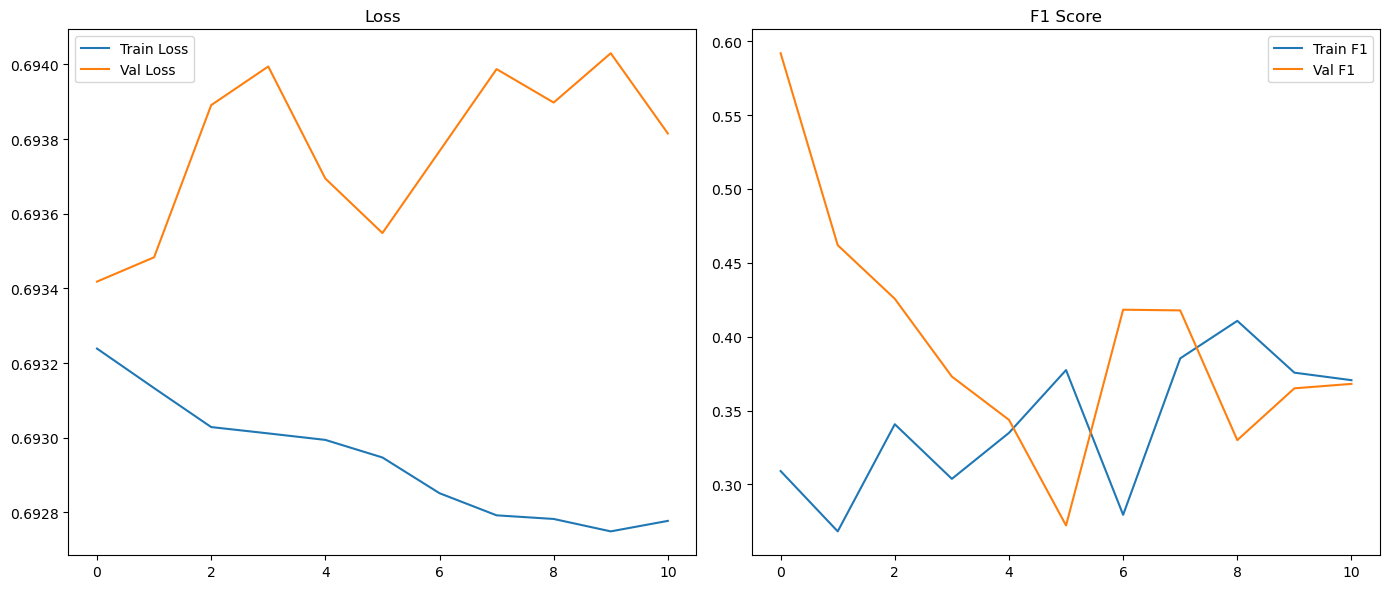

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


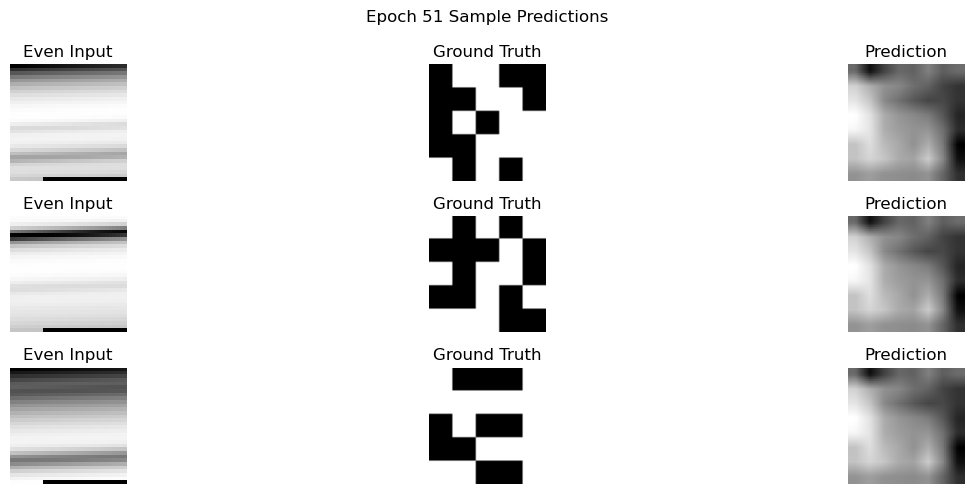

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import warnings

warnings.filterwarnings('ignore')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Path configuration
base_dir = "F:/Education/NSU/CSE/CSE499/Implementation/Image Data"
even_dir = os.path.join(base_dir, "gray_image", "even_images")
out_dir = os.path.join(base_dir, "matrix")

# Image shapes
input_shape = (32, 32, 3)  # 3 channels for EfficientNet
output_shape = (50, 50, 1)
batch_size = 4
epochs = 50

# --- 🔧 Custom Metrics ---
def f1_score(y_true, y_pred):
    y_pred = tf.round(y_pred)
    tp = tf.reduce_sum(tf.cast(y_true * y_pred, 'float32'))
    precision = tp / (tf.reduce_sum(tf.cast(y_pred, 'float32')) + 1e-8)
    recall = tp / (tf.reduce_sum(tf.cast(y_true, 'float32')) + 1e-8)
    return 2 * precision * recall / (precision + recall + 1e-8)

# --- 🧠 Model Definition (EfficientNet + Decoder) ---
def build_unet_efficientnet(input_shape, output_shape):
    base_model = tf.keras.applications.EfficientNetB0(
        input_shape=input_shape, include_top=False, weights='imagenet'
    )
    base_model.trainable = False  # freeze for speed

    inputs = layers.Input(shape=input_shape)
    x = tf.keras.applications.efficientnet.preprocess_input(inputs)
    x = base_model(x, training=False)

    # Decoder
    x = layers.Conv2D(256, 3, activation='relu', padding='same')(x)
    x = layers.UpSampling2D(2)(x)
    x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
    x = layers.UpSampling2D(2)(x)
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.UpSampling2D(2)(x)
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(x)
    x = layers.Conv2D(1, 1, activation='sigmoid')(x)
    output = layers.Resizing(output_shape[0], output_shape[1])(x)

    return models.Model(inputs, output)

# --- 🔄 Data Generator ---
class EvenImageGenerator(Sequence):
    def __init__(self, even_paths, output_paths, input_shape, output_shape, batch_size):
        self.even_paths = even_paths
        self.output_paths = output_paths
        self.input_shape = input_shape
        self.output_shape = output_shape
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.even_paths) / self.batch_size))

    def __getitem__(self, idx):
        batch_even = self.even_paths[idx * self.batch_size: (idx + 1) * self.batch_size]
        batch_out = self.output_paths[idx * self.batch_size: (idx + 1) * self.batch_size]

        X = np.zeros((len(batch_even), *self.input_shape), dtype=np.float32)
        Y = np.zeros((len(batch_even), *self.output_shape), dtype=np.float32)

        for i, (even_path, out_path) in enumerate(zip(batch_even, batch_out)):
            even_img = Image.open(even_path).convert('RGB').resize(self.input_shape[:2])
            mask_img = Image.open(out_path).convert('L').resize(self.output_shape[:2])

            X[i] = np.array(even_img).astype(np.float32) / 255.0
            Y[i] = np.expand_dims((np.array(mask_img) > 30).astype(np.float32), axis=-1)

        return X, Y

# --- 🔍 Helper: Get valid even-output pairs ---
def get_even_pairs():
    even_paths, output_paths = [], []
    for fname in os.listdir(out_dir):
        if not fname.endswith(".png"):
            continue
        base = fname.replace(".png", "")
        even_img = os.path.join(even_dir, f"{base}_even.png")
        out_img = os.path.join(out_dir, fname)
        if os.path.exists(even_img):
            even_paths.append(even_img)
            output_paths.append(out_img)
    return even_paths, output_paths

# --- 📊 Visualize Predictions ---
def visualize_prediction(model, gen, epoch):
    X, Y_true = gen.__getitem__(0)
    Y_pred = model.predict(X)

    plt.figure(figsize=(15, 5))
    for i in range(min(3, X.shape[0])):
        plt.subplot(3, 3, i*3+1)
        plt.imshow(X[i].astype(np.float32))
        plt.title("Even Input")
        plt.axis('off')

        plt.subplot(3, 3, i*3+2)
        plt.imshow(Y_true[i].squeeze(), cmap='gray')
        plt.title("Ground Truth")
        plt.axis('off')

        plt.subplot(3, 3, i*3+3)
        plt.imshow(Y_pred[i].squeeze(), cmap='gray')
        plt.title("Prediction")
        plt.axis('off')
    plt.suptitle(f"Epoch {epoch + 1} Sample Predictions")
    plt.tight_layout()
    plt.show()

# --- 🚀 Training Setup ---
even_paths, output_paths = get_even_pairs()
print(f"Found {len(even_paths)} valid (even-only) pairs.")

# Shuffle and split
pairs = list(zip(even_paths, output_paths))
np.random.shuffle(pairs)
split = int(0.8 * len(pairs))
train_pairs = pairs[:split]
val_pairs = pairs[split:]

train_gen = EvenImageGenerator(
    [p[0] for p in train_pairs], [p[1] for p in train_pairs],
    input_shape, output_shape, batch_size
)
val_gen = EvenImageGenerator(
    [p[0] for p in val_pairs], [p[1] for p in val_pairs],
    input_shape, output_shape, batch_size
)

model = build_unet_efficientnet(input_shape, output_shape)
model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-4, weight_decay=1e-5),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.BinaryIoU(target_class_ids=[1], name='iou'),
        f1_score
    ]
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_iou', patience=10, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5),
    tf.keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True)
]

# --- 🎯 Training ---
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs,
    callbacks=callbacks,
    verbose=1
)

# --- 📈 Plot Metrics ---
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.legend(); plt.title("Loss")

plt.subplot(1, 2, 2)
plt.plot(history.history['f1_score'], label="Train F1")
plt.plot(history.history['val_f1_score'], label="Val F1")
plt.legend(); plt.title("F1 Score")
plt.tight_layout()
plt.show()

# --- 🔍 Final Visualization ---
visualize_prediction(model, val_gen, epoch=epochs)


In [ ]:
# Add Hyper parametre tuning.

Trial 10 Complete [00h 04m 18s]
val_iou: 0.26036134362220764

Best val_iou So Far: 0.48382073640823364
Total elapsed time: 00h 20m 03s
Epoch 1/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 22s 53ms/step - accuracy: 0.5033 - f1_score: 0.0161 - iou: 0.0194 - loss: 0.6932 - precision: 0.4648 - recall: 0.0235 - val_accuracy: 0.5109 - val_f1_score: 0.0000e+00 - val_iou: 0.0000e+00 - val_loss: 0.6931 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step - accuracy: 0.5044 - f1_score: 0.0000e+00 - iou: 0.0000e+00 - loss: 0.6931 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.5109 - val_f1_score: 0.0000e+00 - val_iou: 0.0000e+00 - val_loss: 0.6931 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.4983 - f1_score: 0.0000e+00 - iou: 0.0000e+00 - loss: 0.6932 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.5109 

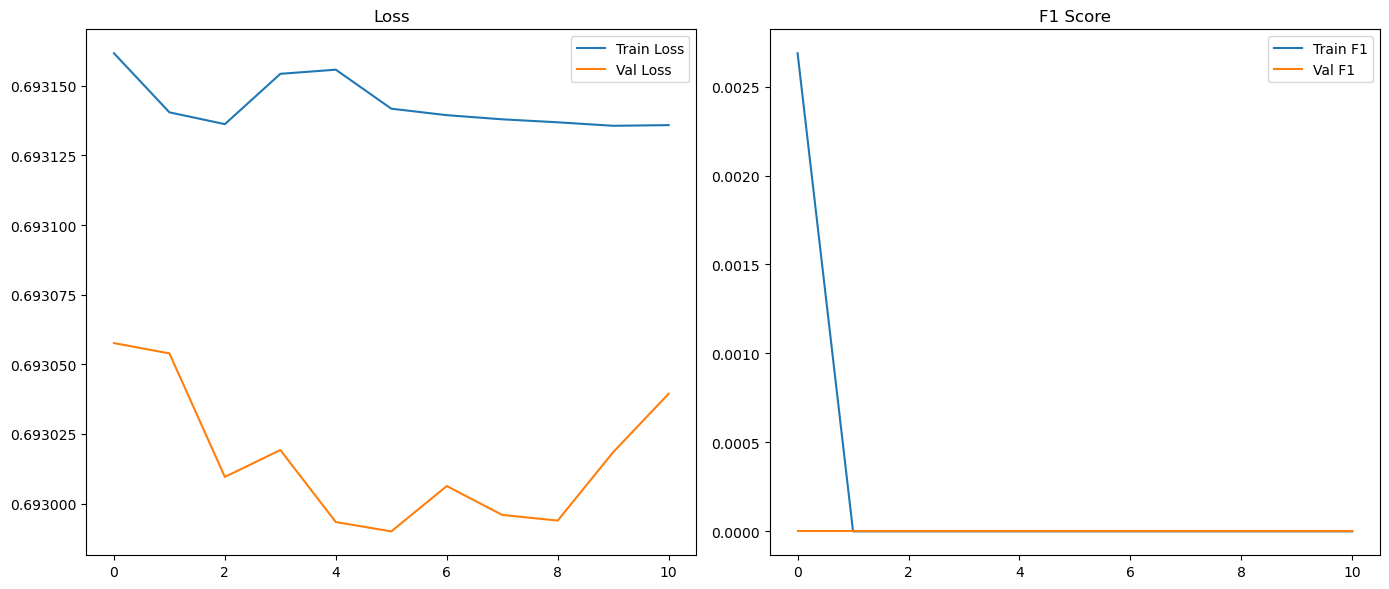

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


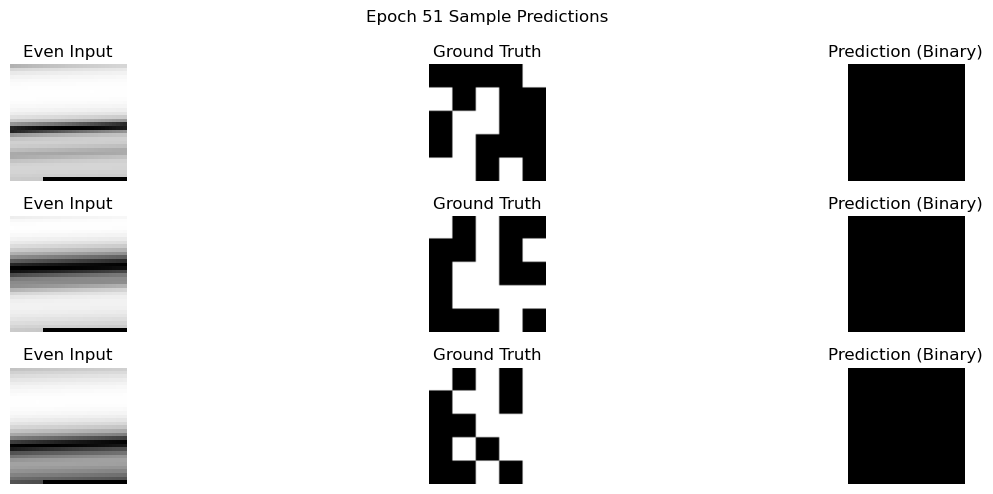

In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import warnings
import keras_tuner as kt

warnings.filterwarnings('ignore')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Path configuration
base_dir = "F:/Education/NSU/CSE/CSE499/Implementation/Image Data"
even_dir = os.path.join(base_dir, "gray_image", "even_images")
out_dir = os.path.join(base_dir, "matrix")

# Image shapes
input_shape = (32, 32, 3)  # 3 channels for EfficientNet
output_shape = (50, 50, 1)
batch_size = 4
epochs = 50
max_trials = 10  # Number of hyperparameter combinations to try
executions_per_trial = 1  # Number of executions per trial

# --- 🔧 Custom Metrics ---
def f1_score(y_true, y_pred):
    y_pred = tf.round(y_pred)
    tp = tf.reduce_sum(tf.cast(y_true * y_pred, 'float32'))
    precision = tp / (tf.reduce_sum(tf.cast(y_pred, 'float32')) + 1e-8)
    recall = tp / (tf.reduce_sum(tf.cast(y_true, 'float32')) + 1e-8)
    return 2 * precision * recall / (precision + recall + 1e-8)

# --- 🧠 Model Definition (EfficientNet + Decoder) with Hyperparameters ---
def build_unet_efficientnet(hp):
    base_model = tf.keras.applications.EfficientNetB0(
        input_shape=input_shape, include_top=False, weights='imagenet'
    )
    base_model.trainable = False  # freeze for speed

    inputs = layers.Input(shape=input_shape)
    x = tf.keras.applications.efficientnet.preprocess_input(inputs)
    x = base_model(x, training=False)

    # Decoder with tunable number of filters
    filters_1 = hp.Int('filters_1', min_value=128, max_value=512, step=64)
    filters_2 = hp.Int('filters_2', min_value=64, max_value=256, step=32)
    filters_3 = hp.Int('filters_3', min_value=32, max_value=128, step=16)
    
    x = layers.Conv2D(filters_1, 3, activation='relu', padding='same')(x)
    x = layers.UpSampling2D(2)(x)
    x = layers.Conv2D(filters_2, 3, activation='relu', padding='same')(x)
    x = layers.UpSampling2D(2)(x)
    x = layers.Conv2D(filters_3, 3, activation='relu', padding='same')(x)
    x = layers.UpSampling2D(2)(x)
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(x)
    x = layers.Conv2D(1, 1, activation='sigmoid')(x)
    output = layers.Resizing(output_shape[0], output_shape[1])(x)

    model = models.Model(inputs, output)
    
    # Tune learning rate
    learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])
    
    model.compile(
        optimizer=tf.keras.optimizers.AdamW(learning_rate=learning_rate, weight_decay=1e-5),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),  # Corrected from Pressure
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.BinaryIoU(target_class_ids=[1], name='iou'),
            f1_score
        ]
    )
    
    return model

# --- 🔄 Data Generator ---
class EvenImageGenerator(Sequence):
    def __init__(self, even_paths, output_paths, input_shape, output_shape, batch_size):
        self.even_paths = even_paths
        self.output_paths = output_paths
        self.input_shape = input_shape
        self.output_shape = output_shape
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.even_paths) / self.batch_size))

    def __getitem__(self, idx):
        batch_even = self.even_paths[idx * self.batch_size: (idx + 1) * self.batch_size]
        batch_out = self.output_paths[idx * self.batch_size: (idx + 1) * self.batch_size]

        X = np.zeros((len(batch_even), *self.input_shape), dtype=np.float32)
        Y = np.zeros((len(batch_even), *self.output_shape), dtype=np.float32)

        for i, (even_path, out_path) in enumerate(zip(batch_even, batch_out)):
            even_img = Image.open(even_path).convert('RGB').resize(self.input_shape[:2])
            mask_img = Image.open(out_path).convert('L').resize(self.output_shape[:2])

            X[i] = np.array(even_img).astype(np.float32) / 255.0
            Y[i] = np.expand_dims((np.array(mask_img) > 30).astype(np.float32), axis=-1)

        return X, Y

# --- 🔍 Helper: Get valid even-output pairs ---
def get_even_pairs():
    even_paths, output_paths = [], []
    for fname in os.listdir(out_dir):
        if not fname.endswith(".png"):
            continue
        base = fname.replace(".png", "")
        even_img = os.path.join(even_dir, f"{base}_even.png")
        out_img = os.path.join(out_dir, fname)
        if os.path.exists(even_img):
            even_paths.append(even_img)
            output_paths.append(out_img)
    return even_paths, output_paths

# --- 📊 Visualize Predictions with Binary Output ---
def visualize_prediction(model, gen, epoch):
    X, Y_true = gen.__getitem__(0)
    Y_pred = model.predict(X)
    # Apply threshold to ensure binary (black or white) output
    Y_pred_binary = (Y_pred > 0.5).astype(np.float32)

    plt.figure(figsize=(15, 5))
    for i in range(min(3, X.shape[0])):
        plt.subplot(3, 3, i*3+1)
        plt.imshow(X[i].astype(np.float32))
        plt.title("Even Input")
        plt.axis('off')

        plt.subplot(3, 3, i*3+2)
        plt.imshow(Y_true[i].squeeze(), cmap='gray', vmin=0, vmax=1)
        plt.title("Ground Truth")
        plt.axis('off')

        plt.subplot(3, 3, i*3+3)
        plt.imshow(Y_pred_binary[i].squeeze(), cmap='gray', vmin=0, vmax=1)
        plt.title("Prediction (Binary)")
        plt.axis('off')
    plt.suptitle(f"Epoch {epoch + 1} Sample Predictions")
    plt.tight_layout()
    plt.show()

# --- 🚀 Training Setup ---
even_paths, output_paths = get_even_pairs()
print(f"Found {len(even_paths)} valid (even-only) pairs.")

# Shuffle and split
pairs = list(zip(even_paths, output_paths))
np.random.shuffle(pairs)
split = int(0.8 * len(pairs))
train_pairs = pairs[:split]
val_pairs = pairs[split:]

train_gen = EvenImageGenerator(
    [p[0] for p in train_pairs], [p[1] for p in train_pairs],
    input_shape, output_shape, batch_size
)
val_gen = EvenImageGenerator(
    [p[0] for p in val_pairs], [p[1] for p in val_pairs],
    input_shape, output_shape, batch_size
)

# --- 🔧 Hyperparameter Tuning ---
tuner = kt.RandomSearch(
    build_unet_efficientnet,
    objective=kt.Objective('val_iou', direction='max'),
    max_trials=max_trials,
    executions_per_trial=executions_per_trial,
    directory='hyperparam_tuning',
    project_name='unet_efficientnet'
)

# Perform hyperparameter search
tuner.search(
    train_gen,
    validation_data=val_gen,
    epochs=20,  # Reduced epochs for tuning
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_iou', patience=5, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
    ],
    verbose=1
)

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# --- 🎯 Training with Best Hyperparameters ---
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_iou', patience=10, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5),
    tf.keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True)
]

history = best_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs,
    callbacks=callbacks,
    verbose=1
)

# --- 📈 Plot Metrics ---
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.legend(); plt.title("Loss")

plt.subplot(1, 2, 2)
plt.plot(history.history['f1_score'], label="Train F1")
plt.plot(history.history['val_f1_score'], label="Val F1")
plt.legend(); plt.title("F1 Score")
plt.tight_layout()
plt.show()

# --- 🔍 Final Visualization ---
visualize_prediction(best_model, val_gen, epoch=epochs)

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import Sequence
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import warnings
import keras_tuner as kt

warnings.filterwarnings('ignore')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Path configuration
base_dir = "F:/Education/NSU/CSE/CSE499/Implementation/Image Data"
even_dir = os.path.join(base_dir, "gray_image", "even_images")
out_dir = os.path.join(base_dir, "matrix")

# Image shapes
input_shape = (32, 32, 3)  # 3 channels for RGB input
output_shape = (32, 32, 1)  # Match input spatial dimensions for simplicity
batch_size = 8
epochs = 100
max_trials = 15
executions_per_trial = 1

# --- 🔧 Custom Metrics and Loss ---
def f1_score(y_true, y_pred):
    y_pred = tf.round(y_pred)
    tp = tf.reduce_sum(tf.cast(y_true * y_pred, 'float32'))
    precision = tp / (tf.reduce_sum(tf.cast(y_pred, 'float32')) + 1e-8)
    recall = tp / (tf.reduce_sum(tf.cast(y_true, 'float32')) + 1e-8)
    return 2 * precision * recall / (precision + recall + 1e-8)

def dice_loss(y_true, y_pred):
    y_true_f = tf.cast(tf.reshape(y_true, [-1]), 'float32')
    y_pred_f = tf.cast(tf.reshape(y_pred, [-1]), 'float32')
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + 1e-8) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + 1e-8)

def combined_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    return bce + dice_loss(y_true, y_pred)

# --- 🧠 Model Definition (Simplified U-Net) ---
def build_unet(hp):
    inputs = layers.Input(shape=input_shape)
    
    # Encoder
    filters_1 = hp.Int('filters_1', min_value=32, max_value=128, step=32)
    x = layers.Conv2D(filters_1, 3, padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters_1, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    p1 = layers.MaxPooling2D((2, 2))(x)  # Shape: (None, 16, 16, filters_1)
    
    filters_2 = hp.Int('filters_2', min_value=64, max_value=256, step=64)
    x = layers.Conv2D(filters_2, 3, padding='same', activation='relu')(p1)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters_2, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    
    # Decoder
    x = layers.Conv2DTranspose(filters_1, 3, strides=2, padding='same', activation='relu')(x)  # Shape: (None, 32, 32, filters_1)
    x = layers.BatchNormalization()(x)
    x = layers.Concatenate()([x, inputs])  # Concatenate with inputs (shape: (None, 32, 32, 3))
    x = layers.Conv2D(filters_1, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters_1, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    
    # Output
    x = layers.Conv2D(1, 1, activation='sigmoid')(x)
    output = layers.Resizing(output_shape[0], output_shape[1])(x)
    
    model = models.Model(inputs, output)
    
    # Tune learning rate
    learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    
    model.compile(
        optimizer=optimizer,
        loss=combined_loss,
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.BinaryIoU(target_class_ids=[1], name='iou'),
            f1_score
        ]
    )
    
    return model

# --- 🔄 Data Generator ---
class EvenImageGenerator(Sequence):
    def __init__(self, even_paths, output_paths, input_shape, output_shape, batch_size):
        self.even_paths = even_paths
        self.output_paths = output_paths
        self.input_shape = input_shape
        self.output_shape = output_shape
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.even_paths) / self.batch_size))

    def __getitem__(self, idx):
        batch_even = self.even_paths[idx * self.batch_size: (idx + 1) * self.batch_size]
        batch_out = self.output_paths[idx * self.batch_size: (idx + 1) * self.batch_size]

        X = np.zeros((len(batch_even), *self.input_shape), dtype=np.float32)
        Y = np.zeros((len(batch_even), *self.output_shape), dtype=np.float32)

        for i, (even_path, out_path) in enumerate(zip(batch_even, batch_out)):
            even_img = Image.open(even_path).convert('RGB').resize(self.input_shape[:2])
            mask_img = Image.open(out_path).convert('L').resize(self.output_shape[:2])

            X[i] = np.array(even_img).astype(np.float32) / 255.0
            Y[i] = np.expand_dims((np.array(mask_img) > 127).astype(np.float32), axis=-1)  # Binary threshold

        return X, Y

# --- 🔍 Helper: Get valid even-output pairs ---
def get_even_pairs():
    even_paths, output_paths = [], []
    for fname in os.listdir(out_dir):
        if not fname.endswith(".png"):
            continue
        base = fname.replace(".png", "")
        even_img = os.path.join(even_dir, f"{base}_even.png")
        out_img = os.path.join(out_dir, fname)
        if os.path.exists(even_img):
            even_paths.append(even_img)
            output_paths.append(out_img)
    return even_paths, output_paths

# --- 📊 Visualize Predictions with Binary Output ---
def visualize_prediction(model, gen, epoch):
    X, Y_true = gen.__getitem__(0)
    Y_pred = model.predict(X)
    Y_pred_binary = (Y_pred > 0.5).astype(np.float32)

    plt.figure(figsize=(15, 5))
    for i in range(min(3, X.shape[0])):
        plt.subplot(3, 3, i*3+1)
        plt.imshow(X[i].astype(np.float32))
        plt.title("Even Input")
        plt.axis('off')

        plt.subplot(3, 3, i*3+2)
        plt.imshow(Y_true[i].squeeze(), cmap='gray', vmin=0, vmax=1)
        plt.title("Ground Truth")
        plt.axis('off')

        plt.subplot(3, 3, i*3+3)
        plt.imshow(Y_pred_binary[i].squeeze(), cmap='gray', vmin=0, vmax=1)
        plt.title("Prediction (Binary)")
        plt.axis('off')
    plt.suptitle(f"Epoch {epoch + 1} Sample Predictions")
    plt.tight_layout()
    plt.show()

# --- 🚀 Training Setup ---
even_paths, output_paths = get_even_pairs()
print(f"Found {len(even_paths)} valid (even-only) pairs.")

# Shuffle and split
pairs = list(zip(even_paths, output_paths))
np.random.shuffle(pairs)
split = int(0.8 * len(pairs))
train_pairs = pairs[:split]
val_pairs = pairs[split:]

train_gen = EvenImageGenerator(
    [p[0] for p in train_pairs], [p[1] for p in train_pairs],
    input_shape, output_shape, batch_size
)
val_gen = EvenImageGenerator(
    [p[0] for p in val_pairs], [p[1] for p in val_pairs],
    input_shape, output_shape, batch_size
)

# --- 🔧 Hyperparameter Tuning ---
tuner = kt.RandomSearch(
    build_unet,
    objective=kt.Objective('val_accuracy', direction='max'),
    max_trials=max_trials,
    executions_per_trial=executions_per_trial,
    directory='hyperparam_tuning',
    project_name='unet_segmentation'
)

# Perform hyperparameter search
tuner.search(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
    ],
    verbose=1
)

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# --- 🎯 Training with Best Hyperparameters ---
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5),
    tf.keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True, monitor='val_accuracy')
]

history = best_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs,
    callbacks=callbacks,
    verbose=1
)

# --- 📈 Plot Metrics ---
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.legend(); plt.title("Loss")

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Val Accuracy")
plt.legend(); plt.title("Accuracy")
plt.tight_layout()
plt.show()

# --- 🔍 Final Visualization ---
visualize_prediction(best_model, val_gen, epoch=epochs)


Trial 12 Complete [00h 01m 12s]
val_accuracy: 0.5312584042549133

Best val_accuracy So Far: 0.5356214642524719
Total elapsed time: 00h 24m 20s

Search: Running Trial #13

Value             |Best Value So Far |Hyperparameter
64                |128               |filters_1
256               |128               |filters_2
0.0001            |0.001             |learning_rate

Epoch 1/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step - accuracy: 0.5087 - f1_score: 0.5124 - iou: 0.3451 - loss: 1.2523 - precision: 0.5026 - recall: 0.5241 - val_accuracy: 0.5020 - val_f1_score: 0.4703 - val_iou: 0.3110 - val_loss: 1.1958 - val_precision: 0.5000 - val_recall: 0.4515 - learning_rate: 1.0000e-04
Epoch 2/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.5287 - f1_score: 0.5744 - iou: 0.4038 - loss: 1.1834 - precision: 0.5137 - recall: 0.6539 - val_accuracy: 0.4934 - val_f1_score: 0.5965 - val_iou: 0.4286 - val_loss: 1.1861 - val_precision: 0.4943 - val_recall: 0.7631 - learning_rate: 1.0000e-04
